# Feature Engineering

In [10]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import xgboost as xgb
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load dataframe
# loans = pd.read_csv('./data/accepted_imputed.csv', low_memory=False)
# loans = loans.assign(issue_d=pd.to_datetime(loans['issue_d'], format='%Y-%m-%d'))

loans = pd.read_csv('./data/final.df.csv', low_memory=False)

loans = loans[(loans['loan_status'] == 'Fully Paid') | (loans['loan_status'] == 'Charged Off') | (loans['loan_status'] == 'Default')]
loans = loans.assign(paid_flag = np.where(loans['loan_status'].str.contains('Fully Paid'), 1, 0))

# loans = loans.drop(['loan_status', 'last_fico_range_high', 'last_fico_range_low', 'policy_code'], axis=1) # it depends on loan_status
loans = loans.drop(['loan_status', 'last_fico_range_high', 'last_fico_range_low'], axis=1)

In [107]:
# under sampling
# loans_paid = loans[loans['paid_flag'] == 1].sample(int(len(loans) * 0.2))
# loans_default = loans[loans['paid_flag'] == 0]

# loans = pd.concat([loans_paid, loans_default])
loans['paid_flag'].value_counts()

1    107725
0     92275
Name: paid_flag, dtype: int64

In [ ]:
# select only numeric variables
target_col = []
col_null_cnt = loans.isnull().sum().sort_values(ascending=False)
for k, v in col_null_cnt.iteritems():
    if v == 0:
        if is_numeric_dtype(loans[k].dtype) and k != 'paid_flag':
            target_col = target_col + [k]

# loans = loans[target_col]

In [3]:
# dummify
target = loans['paid_flag']
loans = loans.drop(['paid_flag'], axis=1)

loans = pd.get_dummies(loans, drop_first=True)
loans_norm = preprocessing.normalize(loans)

# seprate training & test set
X_train, X_test, Y_train, Y_test = train_test_split(loans_norm, target, shuffle=True, test_size=0.2)

# Modeling

### 1. Logistic Regression

In [8]:
logit = linear_model.LogisticRegression(solver='liblinear')

param = dict(C=np.logspace(0, 4, 10), penalty=['l1', 'l2'])

logit_grid = GridSearchCV(logit, param, cv=5, verbose=0)

best_mdl = logit_grid.fit(X_train, Y_train)

# best hyperparameter
print('best hyperparameter')
print(best_mdl.best_estimator_.get_params())
print()

# best cross-validation score
print('best cross-validation score: ' + str(best_mdl.score(X_train, Y_train)))
print()

Y_pred = logit_grid.predict(X_test)

rmse = sqrt(mean_squared_error(Y_test, Y_pred))

print('Root Mean Square Error: ' + str(rmse))
print()

print('Accuracy: ' + str(np.mean(Y_test == Y_pred)))
print()

print(confusion_matrix(Y_test, Y_pred))

best hyperparameter
{'C': 3593.813663804626, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

best cross-validation score: 0.9959875

Root Mean Square Error: 0.06999999999999999

Accuracy: 0.9951

[[18428   164]
 [   32 21376]]


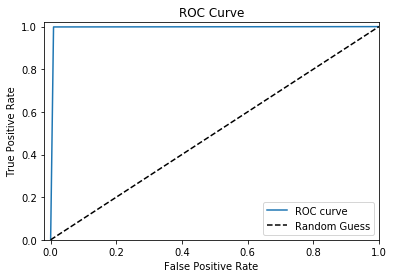

In [11]:
# visualize ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc='lower right')

### 2. Support Vector Classification 

In [ ]:
svc_mdl = SVC()

param = dict(kernel=['rbf', 'linear'])

svc_grid = GridSearchCV(svc_mdl, param, cv=5, verbose=0)

best_mdl = svc_grid.fit(X_train, Y_train)

# best hyperparameter
print('best hyperparameter')
print(best_mdl.best_estimator_.get_params())
print()

# best cross-validation score
print('best cross-validation score: ' + str(best_mdl.score(X_train, Y_train)))
print()

Y_pred = svc_grid.predict(X_test)

rmse = sqrt(mean_squared_error(Y_test, Y_pred))

print('Root Mean Square Error: ' + str(rmse))
print()

print('Accuracy: ' + str(np.mean(Y_test == Y_pred)))
print()

print(confusion_matrix(Y_test, Y_pred))

### 3. XGBoost

In [12]:
xgb_mdl = xgb.XGBClassifier()

param = dict(max_depth=[3,6])

xgb_grid = GridSearchCV(xgb_mdl, param, n_jobs=5, cv=5, verbose=0)

best_mdl = xgb_grid.fit(X_train, Y_train)

# best hyperparameter
print('best hyperparameter')
print(best_mdl.best_estimator_.get_params())
print()

# best cross-validation score
print('best cross-validation score: ' + str(best_mdl.score(X_train, Y_train)))
print()

Y_pred = xgb_grid.predict(X_test)

rmse = sqrt(mean_squared_error(Y_test, Y_pred))

print('Root Mean Square Error: ' + str(rmse))
print()

print('Accuracy: ' + str(np.mean(Y_test == Y_pred)))
print()

print(confusion_matrix(Y_test, Y_pred))

best hyperparameter
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}

best cross-validation score: 0.99605625

Root Mean Square Error: 0.07681145747868608

Accuracy: 0.9941

[[18360   232]
 [    4 21404]]


### 4. Deep Learning (Tensorflow)

In [10]:
import tensorflow as tf

In [13]:
tf.reset_default_graph()

dimension = X_train.shape[1]

X = tf.placeholder(dtype=tf.float32, shape=[None, dimension])
Y = tf.placeholder(dtype=tf.float32, shape=[None, 1])
W = tf.Variable(tf.random_normal(shape=[dimension, 1]), dtype=tf.float32)
b = tf.Variable(tf.random_normal(shape=[1, 1]), dtype=tf.float32)

mod = tf.matmul(X, W) + b

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=mod, labels=Y))
opt = tf.train.GradientDescentOptimizer(learning_rate=0.005)
goal = opt.minimize(loss)

prediction = tf.round(tf.sigmoid(mod))
correct = tf.cast(tf.equal(prediction, Y), dtype=tf.float32)
accuracy = tf.reduce_mean(correct)

In [14]:
loss_trace = []
train_acc = []
test_acc = []

batch_size = 500
iter_num = 50000

init = tf.global_variables_initializer()

Y_train = Y_train.reset_index(drop=True)

with tf.Session() as sess:
    init.run()
    for epoch in range(iter_num):
        batch_index = np.random.choice(len(X_train), size=batch_size)

        batch_train_X = X_train[batch_index]
        batch_train_y = np.matrix(Y_train[batch_index]).T
        
        sess.run(goal, feed_dict={X: batch_train_X, Y: batch_train_y})
        temp_loss = sess.run(loss, feed_dict={X: batch_train_X, Y: batch_train_y})

        temp_train_acc = sess.run(accuracy, feed_dict={X: X_train, Y: np.matrix(Y_train).T})
        temp_test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: np.matrix(Y_test).T})

        loss_trace.append(temp_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)

        if (epoch + 1) % 500 == 0:
            print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss, temp_train_acc, temp_test_acc))

epoch:  500 loss: 0.732912 train_acc: 0.512969 test_acc: 0.513750
epoch: 1000 loss: 0.728505 train_acc: 0.523313 test_acc: 0.524250
epoch: 1500 loss: 0.722849 train_acc: 0.525825 test_acc: 0.525850
epoch: 2000 loss: 0.691261 train_acc: 0.527669 test_acc: 0.527275
epoch: 2500 loss: 0.724209 train_acc: 0.529688 test_acc: 0.528000
epoch: 3000 loss: 0.710634 train_acc: 0.531219 test_acc: 0.529150
epoch: 3500 loss: 0.688719 train_acc: 0.532694 test_acc: 0.530575
epoch: 4000 loss: 0.713874 train_acc: 0.534725 test_acc: 0.532750
epoch: 4500 loss: 0.689381 train_acc: 0.537138 test_acc: 0.534200
epoch: 5000 loss: 0.700802 train_acc: 0.539237 test_acc: 0.536275


KeyboardInterrupt: 